In [1]:
# Loops through all stocks on Alpaca and ranks based on Facebook Prophet
# Plots top ranked stocks

In [2]:
#check python version
import sys
print(sys.version)

3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]


In [3]:
#import packages needed
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import alpaca_trade_api as tradeapi
from prophet import Prophet
from datetime import date, timedelta, datetime

/Users/omer/opt/miniconda3/envs/proph/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [4]:
# Turn off pystan warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

# Turn off fbprophet stdout logger
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

# Class to supress pystan warnings
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [5]:
# API Info for fetching data, portfolio, etc. from Alpaca
BASE_URL = "https://paper-api.alpaca.markets"
ALPACA_API_KEY = "--"
ALPACA_SECRET_KEY = "--"

# Instantiate REST API Connection
api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, base_url=BASE_URL, api_version='v2')
# Fetch Account
account = api.get_account()
# Print Account Details
#print("account id: ")
#print(account.id)
print("equity: ")
print(account.equity)
print("status: ")
print(account.status)

account id: 
6c057de8-2343-4636-b194-9b580a06c9c2
equity: 
97862.69
status: 
ACTIVE


In [6]:
#Get list of all active assets
active_assets = api.list_assets(status='active')
print(len(active_assets))

# Filter the assets down to just those are tradable, shortable, and easy to borrow
cleared_assets = [a for a in active_assets if a.tradable and a.shortable and a.easy_to_borrow]
print(len(cleared_assets))

11103
5253


In [7]:
# Loop through all assets and rank them all
ranks = []

daycount = 10 # how many days to get data for

today = datetime.now() - timedelta(minutes=15, hours=-4)
d1 = (today).isoformat() + "Z"
d2 = (date.today() - timedelta(days=daycount)).strftime("%Y-%m-%d")

ntot = 0
skip = 0
# Start clock for timing
start = datetime.now()
print("start:")
print(start)
print()
for asset in cleared_assets:
    print(f"{asset.symbol}  \t{asset.name}")
    # Fetch training set for asset data from last 100 days
    traindata = api.get_bars_iter(asset.symbol, tradeapi.TimeFrame.Minute, d2, d1, adjustment='raw')
    # Create input for prophet
    i = 0

    vol = 0
    for bar in traindata:
        vol += bar.v
        if(i == 0):
            tra = np.array([[bar.t.tz_localize(None), bar.o]])
            
        else:
            tra = np.append(tra, np.array([[bar.t.tz_localize(None), bar.o]]), axis=0)
        i = i + 1
    # check that there are more than 2 days of data (needed for Prophet)
    # check that there is more than 1m avg volume per day
    if(i > 2 and vol/daycount > 1000000):
        train = pd.DataFrame(tra)
        train.columns = ['ds', 'y']
        # Init Prophet and fit

        m = Prophet()
        with suppress_stdout_stderr():
            m.fit(train)

        # Extend time frame by 1 period
        future = m.make_future_dataframe(periods=1)
        # Restrict predictions to trading hours (weekly, 4 am to 8 pm)
        future = future[future['ds'].dt.hour > 6]
        future = future[future['ds'].dt.hour < 20]
        future = future[future['ds'].dt.dayofweek < 5]
        # Forecast
        forecast = m.predict(future)
        # rank stock among other stocks
        rank = abs(forecast.at[len(forecast)-2, 'yhat'] - forecast.at[len(forecast)-1, 'yhat'])/(forecast.at[len(forecast)-2, 'yhat'] + forecast.at[len(forecast)-1, 'yhat'])/2
        if(forecast.at[len(forecast)-2, 'yhat'] > forecast.at[len(forecast)-1, 'yhat']):
            if(rank > 0):
                rank = rank * -1
        else:
            rank = abs(rank)
        print(rank)
        x = 0
        while(len(ranks) > x):
            if(abs(rank) > abs(ranks[x]['rank'])):
                ranks = np.insert(ranks, x, [{'symbol':asset.symbol, 'rank':rank, 'm':m, 'forecast':forecast}], axis = 0)
                x = len(ranks)+1
            x = x + 1
        if(x == len(ranks)):
            ranks = np.append(ranks, [{'symbol':asset.symbol, 'rank':rank, 'm':m, 'forecast':forecast}], axis = 0)
    else:
        print("skipped")
        skip = skip + 1
    ntot = ntot+1
    
    print(str(ntot) + " (" + str(100*ntot/len(cleared_assets)) + "%)")

#end clock
end = datetime.now()
print()
print("end:")
print(end)
print("elapsed time for loop:")
print(end-start)
print("skipped:")
print(skip)


start:
2022-07-10 13:05:55.335817

QDIV  	Global X S&P 500 Quality Dividend ETF
skipped
1 (0.019036740909956214%)
LFAC  	LF Capital Acquisition Corp. II Class A Common Stock
skipped
2 (0.03807348181991243%)
DFAS  	Dimensional U.S. Small Cap ETF
skipped
3 (0.05711022272986865%)
XLB  	Materials Select Sector SPDR Fund
-8.540867226282431e-05
4 (0.07614696363982486%)
XLC  	The Communication Services Select Sector SPDR Fund
-2.6463181515197926e-05
5 (0.09518370454978108%)
XLF  	Financial Select Sector SPDR Fund
7.179451867080066e-06
6 (0.1142204454597373%)
XLK  	Technology Select Sector SPDR Fund
0.0003086616791874766
7 (0.1332571863696935%)
FUTY  	Fidelity MSCI Utilities Index ETF
skipped
8 (0.15229392727964972%)
MET  	MetLife, Inc.
-6.343159759380206e-05
9 (0.17133066818960593%)
METC  	Ramaco Resources, Inc. Common Stock
skipped
10 (0.19036740909956215%)
CF  	CF Industries Holding, Inc.
-6.438439091883403e-06
11 (0.20940415000951837%)
MGI  	Moneygram International, Inc. Common Stock
skipp

1.904117013887797e-05
103 (1.9607843137254901%)
APAM  	ARTISAN PARTNERS ASSET MANAGEMENT INC.
skipped
104 (1.9798210546354464%)
MSEX  	Middlesex Water Company Common Stock
skipped
105 (1.9988577955454025%)
FBRT  	Franklin BSP Realty Trust, Inc.
skipped
106 (2.017894536455359%)
MSFT  	Microsoft Corporation Common Stock
0.00015722672266757279
107 (2.036931277365315%)
FRT  	Federal Realty Investment Trust
skipped
108 (2.055968018275271%)
MSOS  	AdvisorShares Pure US Cannabis ETF
skipped
109 (2.0750047591852274%)
MVBF  	MVB Financial Corp. Common Stock
skipped
110 (2.0940415000951837%)
REPL  	Replimune Group, Inc. Common Stock
skipped
111 (2.11307824100514%)
ENLC  	ENLINK MIDSTREAM, LLC
1.4238378789931804e-05
112 (2.132114981915096%)
EOD  	Allspring Global Dividend Opportunity Fund
skipped
113 (2.1511517228250523%)
IWV  	iShares Russell 3000 ETF
skipped
114 (2.1701884637350086%)
MTBC  	CareCloud, Inc. Common Stock
skipped
115 (2.189225204644965%)
EPHY  	Epiphany Technology Acquisition Corp

skipped
210 (3.997715591090805%)
NBIX  	Neurocrine Biosciences, Inc. Common Stock
skipped
211 (4.016752332000761%)
NBSTU  	Newbury Street Acquisition Corporation Units
skipped
212 (4.035789072910718%)
NBTB  	NBT Bancorp Inc. Common Stock
skipped
213 (4.054825813820674%)
NCLH  	Norwegian Cruise Line Holdings Ltd. Ordinary Shares
2.3652762463785183e-05
214 (4.07386255473063%)
NCSM  	NCS Multistage Holdings, Inc. Common Stock
skipped
215 (4.092899295640587%)
TOAC  	Talon 1 Acquisition Corp. Class A Ordinary Shares
skipped
216 (4.111936036550542%)
ARCH  	Arch Resources, Inc.
skipped
217 (4.1309727774604985%)
ATVCU  	Tribe Capital Growth Corp I Units
skipped
218 (4.150009518370455%)
NR  	Newpark Resources, Inc.
skipped
219 (4.169046259280411%)
NRAC  	Noble Rock Acquisition Corporation Class A Ordinary Share
skipped
220 (4.1880830001903675%)
NRACU  	Noble Rock Acquisition Corporation Unit
skipped
221 (4.207119741100324%)
ALGT  	Allegiant Travel Company Common Stock
skipped
222 (4.22615648201

skipped
317 (6.034646868456121%)
ULH  	Universal Logistics Holdings, Inc. Common Stock
skipped
318 (6.053683609366076%)
SQ  	Block, Inc.
6.26683568893983e-05
319 (6.0727203502760325%)
ULST  	SPDR SSgA Ultra Short Term Bond ETF of SSgA Active Trust
skipped
320 (6.091757091185989%)
OMIC  	Singular Genomics Systems, Inc. Common Stock
skipped
321 (6.110793832095945%)
ULTA  	Ulta Beauty, Inc. Common Stock
skipped
322 (6.1298305730059015%)
ON  	ON Semiconductor Corporation Common Stock
0.00033504991652734374
323 (6.148867313915858%)
ONB  	Old National Bancorp Common Stock
0.00022896062462772932
324 (6.167904054825814%)
ONEM  	1Life Healthcare, Inc. Common Stock
0.00038349896528797284
325 (6.18694079573577%)
ONL  	Orion Office REIT Inc.
skipped
326 (6.205977536645726%)
ULTR  	IQ Ultra Short Duration ETF
skipped
327 (6.225014277555682%)
UNFI  	United Natural Foods Inc
skipped
328 (6.244051018465639%)
EMNT  	PIMCO Enhanced Short Maturity Active ESG ETF
skipped
329 (6.263087759375595%)
EMQQ  	EM

skipped
425 (8.090614886731391%)
NGMS  	NeoGames S.A. Ordinary Shares
skipped
426 (8.109651627641348%)
ONEY  	SPDR Russell 1000 Yield Focus ETF
skipped
427 (8.128688368551304%)
WMT  	Walmart Inc.
5.947208020552266e-05
428 (8.14772510946126%)
NHIC  	NewHold Investment Corp. II Class A Common Stock
skipped
429 (8.166761850371216%)
PFFD  	Global X U.S. Preferred ETF
skipped
430 (8.185798591281173%)
PFG  	Principal Financial Group Inc Common Stock
skipped
431 (8.204835332191129%)
PFGC  	Performance Food Group Company
skipped
432 (8.223872073101084%)
PFIN  	P & F Industries, Inc. Class A Common Stock
skipped
433 (8.242908814011042%)
VGK  	Vanguard FTSE Europe ETF
-4.1313710493222514e-06
434 (8.261945554920997%)
VGLT  	Vanguard Long-Term Treasury ETF
skipped
435 (8.280982295830954%)
PGC  	Peapack-Gladstone Financial Corporation Common Stock
skipped
436 (8.30001903674091%)
VHI  	Valhi, Inc.
skipped
437 (8.319055777650867%)
VHT  	Vanguard Health Care ETF
skipped
438 (8.338092518560822%)
PGNY  

skipped
532 (10.127546164096707%)
VNQI  	Vanguard International Equity Index Funds Vanguard Global ex-U.S. Real Estate ETF
skipped
533 (10.146582905006662%)
VONV  	Vanguard Scottsdale Funds Vanguard Russell 1000 Value ETF
skipped
534 (10.16561964591662%)
VOO  	Vanguard S&P 500 ETF
4.325708402338507e-05
535 (10.184656386826575%)
VOOG  	Vanguard S&P 500 Growth ETF
skipped
536 (10.203693127736532%)
VOOV  	Vanguard S&P 500 Value ETF
skipped
537 (10.222729868646487%)
VOR  	Vor Biopharma Inc. Common Stock
skipped
538 (10.241766609556445%)
VOT  	Vanguard Mid-Cap Growth ETF
skipped
539 (10.2608033504664%)
PST  	ProShares Trust UltraShort Lehman 7-10 Year Treasury
skipped
540 (10.279840091376357%)
PSTH  	Pershing Square Tontine Holdings, Ltd.
skipped
541 (10.298876832286313%)
BIPC  	Brookfield Infrastructure Corporation Class A Subordinate Voting Shares
skipped
542 (10.317913573196268%)
MOD  	Modine Manufacturing Co
skipped
543 (10.336950314106225%)
PTGX  	Protagonist Therapeutics, Inc. Common 

skipped
637 (12.12640395964211%)
RF  	Regions Financial Corp.
-0.00010281004271694317
638 (12.145440700552065%)
RETA  	Reata Pharmaceuticals, Inc. Class A Common Stock
skipped
639 (12.164477441462022%)
REVE  	Alpine Acquisition Corporation Common Stock
skipped
640 (12.183514182371978%)
REVHU  	Revolution Healthcare Acquisition Corp. SAIL Units
skipped
641 (12.202550923281935%)
RFG  	Invesco S&P MidCap 400 Pure Growth ETF
skipped
642 (12.22158766419189%)
FET  	Forum Energy Technologies, Inc.
skipped
643 (12.240624405101846%)
RFP  	Resolute Forest Products Inc.
0.00011900263272945678
644 (12.259661146011803%)
RGLD  	Royal Gold, Inc. Common Stock
skipped
645 (12.278697886921758%)
W  	Wayfair Inc.
-0.0009256800340464691
646 (12.297734627831716%)
WABC  	Westamerica Bancorporation Common Stock
skipped
647 (12.316771368741671%)
WAFD  	Washington Federal, Inc. Common Stock
skipped
648 (12.335808109651628%)
WAFDP  	Washington Federal, Inc. Depositary Shares
skipped
649 (12.354844850561584%)
WAL

skipped
740 (14.0871882733676%)
RXDX  	Prometheus Biosciences, Inc. Common Stock
skipped
741 (14.106225014277555%)
RXRX  	Recursion Pharmaceuticals, Inc. Class A Common Stock
skipped
742 (14.125261755187513%)
RXST  	RxSight, Inc. Common Stock
skipped
743 (14.144298496097468%)
RXT  	Rackspace Technology, Inc. Common Stock
skipped
744 (14.163335237007423%)
RY  	Royal Bank of Canada
skipped
745 (14.18237197791738%)
RYAAY  	Ryanair Holdings plc American Depositary Shares
skipped
746 (14.201408718827336%)
RYAN  	Ryan Specialty Holdings, Inc.
skipped
747 (14.220445459737293%)
SPHD  	Invesco S&P 500 High Dividend Low Volatility ETF
skipped
748 (14.239482200647249%)
FATP  	Fat Projects Acquisition Corp Class A Ordinary Share
skipped
749 (14.258518941557206%)
RYI  	RYERSON HOLDING CORPORATION
skipped
750 (14.277555682467161%)
AGCB  	Altimeter Growth Corp. 2
skipped
751 (14.296592423377119%)
RYTM  	Rhythm Pharmaceuticals, Inc. Common Stock
skipped
752 (14.315629164287074%)
AGD  	abrdn Global Dyn

-0.00048480988657463147
845 (16.086046068913003%)
CTS  	CTS Corporation
skipped
846 (16.105082809822957%)
SDS  	ProShares UltraShort S&P500
-0.00036675253583613645
847 (16.124119550732914%)
CTSH  	Cognizant Technology Solutions Corporation Class A Common Stock
5.2353674696153274e-05
848 (16.14315629164287%)
SDY  	SPDR S&P Dividend ETF
skipped
849 (16.16219303255283%)
SE  	Sea Limited American Depositary Shares, each representing one Class A Ordinary Share
0.003517767863203868
850 (16.181229773462782%)
SEAS  	SEAWORLD ENTERTAINMENT INC
skipped
851 (16.20026651437274%)
SEAT  	Vivid Seats Inc. Class A Common Stock
skipped
852 (16.219303255282696%)
AIV  	Apartment Investment and Management Company
2.1780975857281282e-05
853 (16.238339996192654%)
FLKR  	Franklin FTSE South Korea ETF
skipped
854 (16.257376737102607%)
FLL  	Full House Resorts, Inc. Common Stock
skipped
855 (16.276413478012564%)
FLO  	Flowers Foods, Inc.
skipped
856 (16.29545021892252%)
SEB  	Seaboard Corporation
skipped
857 (

skipped
947 (18.027793641728536%)
RGEN  	Repligen Corporation Common Stock
skipped
948 (18.046830382638493%)
XGN  	Exagen Inc. Common Stock
skipped
949 (18.065867123548447%)
SENEA  	Seneca Foods Corp. Class A Common Stock
skipped
950 (18.084903864458404%)
GPC  	Genuine Parts Company
skipped
951 (18.10394060536836%)
SOCL  	Global X Funds Global X Social Media ETF
skipped
952 (18.12297734627832%)
MMX  	Maverix Metals Inc. Common Shares
skipped
953 (18.142014087188272%)
XPOF  	Xponential Fitness, Inc.
skipped
954 (18.16105082809823%)
XPRO  	Expro Group Holdings N.V.
skipped
955 (18.180087569008187%)
YELL  	Yellow Corporation Common Stock
skipped
956 (18.19912430991814%)
YETI  	YETI Holdings, Inc. Common Stock
skipped
957 (18.218161050828098%)
SITC  	SITE Centers Corp. Common Shares
3.6815788183911e-05
958 (18.237197791738055%)
SITE  	SiteOne Landscape Supply, Inc.
skipped
959 (18.256234532648012%)
SITM  	SiTime Corporation Common Stock
skipped
960 (18.275271273557966%)
SIVB  	SVB Financia

skipped
1050 (19.988577955454026%)
SRDX  	Surmodics, Inc. Common Stock
skipped
1051 (20.007614696363984%)
SRG  	Seritage Growth Properties Class A common shares of beneficial interest, par value $0.01
0.000688841438705999
1052 (20.026651437273937%)
SRGA  	Surgalign Holdings, Inc. Common Stock
skipped
1053 (20.045688178183894%)
VEU  	Vanguard FTSE All-World Ex-US ETF
8.240730386441157e-09
1054 (20.06472491909385%)
KNBWY  	Kirin Holdings Company, Limited Sponsored ADR (Japan)
skipped
1055 (20.08376166000381%)
VET  	VERMILION ENERGY INC.
0.0006600222762617612
1056 (20.102798400913763%)
PRPH  	ProPhase Labs, Inc. Common Stock (DE)
skipped
1057 (20.12183514182372%)
SJNK  	SPDR Bloomberg Short Term High Yield Bond ETF
4.173005895074646e-06
1058 (20.140871882733677%)
SJIV  	South Jersey Industries, Inc. Corporate Units
skipped
1059 (20.15990862364363%)
ATEX  	Anterix Inc. Common Stock
skipped
1060 (20.178945364553588%)
SSL  	Sasol Limited
skipped
1061 (20.197982105463545%)
ATGE  	Adtalem Glob

skipped
1155 (21.987435750999428%)
SBCF  	Seacoast Banking Corporation of Florida Common Stock
skipped
1156 (22.006472491909385%)
PLUG  	Plug Power, Inc. Common Stock
1.7916765271736957e-05
1157 (22.025509232819342%)
GAQ  	Generation Asia I Acquisition Limited
skipped
1158 (22.0445459737293%)
PACWP  	PacWest Bancorp Depositary Shares Each Representing a 1/40th Interest in a Share of 7.75% Fixed Rate Non-Cumulative Perpetual Preferred Stock, Series A
skipped
1159 (22.063582714639253%)
IT  	Gartner, Inc.
skipped
1160 (22.08261945554921%)
PAQC  	Provident Acquisition Corp. Class A Ordinary Shares
skipped
1161 (22.101656196459167%)
INAQ  	Insight Acquisition Corp.
skipped
1162 (22.12069293736912%)
NUE  	Nucor Corporation
-1.0344797572361834e-05
1163 (22.13972967827908%)
BIB  	ProShares Trust ProShares Ultra Nasdaq Biotechnology
skipped
1164 (22.158766419189035%)
CEIX  	CONSOL Energy Inc.
skipped
1165 (22.177803160098993%)
SBRA  	Sabra Health Care REIT, Inc. Common Stock
-4.159073525267104e

skipped
1254 (23.872073101085093%)
MRO  	Marathon Oil Corporation
-0.00011182944303150232
1255 (23.89110984199505%)
NCR  	NCR Corporation
skipped
1256 (23.910146582905007%)
AGGRU  	Agile Growth Corp. Units
skipped
1257 (23.929183323814964%)
GDYN  	Grid Dynamics Holdings, Inc. Class A Common Stock
skipped
1258 (23.948220064724918%)
TLT  	iShares 20 Year Treasury Bond ETF
5.4979938918225046e-05
1259 (23.967256805634875%)
TLYS  	Tilly's Inc.
skipped
1260 (23.986293546544832%)
TM  	Toyota Motor Corporation American Depositary Shares (Each representing ten Ordinary Shares)
skipped
1261 (24.005330287454786%)
TMAC  	The Music Acquisition Corporation
skipped
1262 (24.024367028364743%)
ATTO  	Atento S.A.
skipped
1263 (24.0434037692747%)
ATCX  	Atlas Technical Consultants, Inc. Class A Common Stock
skipped
1264 (24.062440510184658%)
TMHC  	Taylor Morrison Home Corporation Common Stock
skipped
1265 (24.08147725109461%)
ATEC  	Alphatec Holdings, Inc. Common Stock
skipped
1266 (24.10051399200457%)


skipped
1358 (25.85189415572054%)
ATI  	Allegheny Technologies
skipped
1359 (25.870930896630497%)
PCX  	Parsec Capital Acquisitions Corp Class A Common Stock
skipped
1360 (25.889967637540455%)
AY  	Atlantica Sustainable Infrastructure plc Ordinary Shares
skipped
1361 (25.90900437845041%)
PDM  	Piedmont Office Realty Trust, Inc.
skipped
1362 (25.928041119360365%)
BAMR  	Brookfield Asset Management Reinsurance Partners Ltd. Class A Exchangeable Limited Voting Shares
skipped
1363 (25.947077860270323%)
BXC  	BlueLinx Holdings Inc.
skipped
1364 (25.966114601180276%)
CFRUY  	Compagnie Financiere Richemont Unsponsored ADR (Switzerland)
skipped
1365 (25.985151342090234%)
BZH  	Beazer Homes USA, Inc. New
skipped
1366 (26.00418808300019%)
VBNK  	VersaBank Common Shares
skipped
1367 (26.023224823910148%)
VBOC  	Viscogliosi Brothers Acquisition Corp Common Stock
skipped
1368 (26.0422615648201%)
CFR  	Cullen/Frost Bankers Inc.
skipped
1369 (26.06129830573006%)
PNQI  	Invesco Exchange-Traded Fund Tr

skipped
1459 (27.77460498762612%)
MCBC  	Macatawa Bank Corporation Common Stock
skipped
1460 (27.793641728536073%)
VB  	Vanguard Small-Cap ETF
skipped
1461 (27.81267846944603%)
CCBG  	Capital City Bank Group Common Stock
skipped
1462 (27.831715210355988%)
DKS  	Dick's Sporting Goods, Inc.
skipped
1463 (27.850751951265945%)
VSTA  	Vasta Platform Limited Class A Ordinary Shares
skipped
1464 (27.8697886921759%)
CLS  	Celestica, Inc.
skipped
1465 (27.888825433085856%)
VSTO  	Vista Outdoor Inc.
skipped
1466 (27.907862173995813%)
SVT  	Servotronics, Inc.
skipped
1467 (27.926898914905767%)
VT  	Vanguard Total World Stock ETF
-7.318120965440735e-07
1468 (27.945935655815724%)
AZPN  	Aspen Technology, Inc. Common Stock
skipped
1469 (27.96497239672568%)
WAT  	Waters Corp
skipped
1470 (27.98400913763564%)
AZRE  	Azure Power Global Limited
skipped
1471 (28.003045878545592%)
AZUL  	Azul S.A. American Depositary Shares (each representing three preferred shares)
0.0005730449425645908
1472 (28.02208261

skipped
1562 (29.73538930135161%)
TCBI  	Texas Capital Bancshares, Inc. Common Stock
skipped
1563 (29.754426042261564%)
PHR  	Phreesia, Inc.
skipped
1564 (29.77346278317152%)
SVNA  	7 Acquisition Corporation Class A Ordinary Shares
skipped
1565 (29.792499524081478%)
KW  	KENNEDY-WILSON HOLDINGS, INC.
skipped
1566 (29.81153626499143%)
SNX  	TD SYNNEX Corporation
skipped
1567 (29.83057300590139%)
SNY  	Sanofi ADS
-0.0006749120461949162
1568 (29.849609746811346%)
SO  	The Southern Company
-0.0001210562797569782
1569 (29.868646487721303%)
SOFI  	SoFi Technologies, Inc. Common Stock
-1.220054579900363e-05
1570 (29.887683228631257%)
TSBK  	Timberland Bancorp, Inc. Common Stock
skipped
1571 (29.906719969541214%)
BAESY  	BAE SYSTEMS plc Sponsored ADR
skipped
1572 (29.92575671045117%)
IRDM  	Iridium Communications Inc Common Stock
skipped
1573 (29.94479345136113%)
VABK  	Virginia National Bankshares Corporation Common Stock
skipped
1574 (29.963830192271082%)
WPCB  	Warburg Pincus Capital Corpor

skipped
1668 (31.75328383780697%)
BBIO  	BridgeBio Pharma, Inc. Common Stock
0.002283760132032038
1669 (31.772320578716922%)
BBQ  	BBQ Holdings, Inc. Common Stock
skipped
1670 (31.79135731962688%)
BDN  	Brandywine Realty Trust
skipped
1671 (31.810394060536836%)
POST  	POST HOLDINGS, INC.
skipped
1672 (31.829430801446794%)
COST  	Costco Wholesale Corporation Common Stock
0.0006138432849464665
1673 (31.848467542356747%)
IMAX  	Imax Corp
skipped
1674 (31.867504283266705%)
EVBN  	Evans Bancorp Inc
skipped
1675 (31.886541024176662%)
LXP  	LXP Industrial Trust
1.827926846189435e-05
1676 (31.905577765086615%)
LAW  	CS Disco, Inc.
skipped
1677 (31.924614505996573%)
IPG  	The Interpublic Group of Companies, Inc.
-2.357407762773742e-05
1678 (31.94365124690653%)
IPI  	Intrepid Potash, Inc
skipped
1679 (31.962687987816487%)
PDOT.U  	Peridot Acquisition Corp. II Units, each consisting of one Class A ordinary share, and one-fifth of
skipped
1680 (31.98172472872644%)
MCRB  	Seres Therapeutics, Inc. C

-0.00015972193793012702
1771 (33.71406815153246%)
DAN  	Dana Incorporated
skipped
1772 (33.73310489244241%)
SHG  	Shinhan Financial Group Co Ltd
skipped
1773 (33.75214163335237%)
ELA  	Envela Corporation
skipped
1774 (33.77117837426233%)
JBAXY  	Julius Baer Group Ltd Unsponsored ADR (Switzerland)
skipped
1775 (33.79021511517228%)
JUGG  	Jaws Juggernaut Acquisition Corporation Class A Ordinary Share
skipped
1776 (33.80925185608224%)
PLL  	Piedmont Lithium Inc. Common Stock
skipped
1777 (33.828288596992195%)
STNE  	StoneCo Ltd. Class A Common Shares
2.7108131679664472e-05
1778 (33.84732533790215%)
STNG  	Scorpio Tankers Inc.
skipped
1779 (33.86636207881211%)
LYB  	LyondellBasell Industries N.V. Class A
-3.475242543420749e-06
1780 (33.88539881972206%)
BWA  	BorgWarner Inc.
-5.568407683662791e-05
1781 (33.90443556063202%)
KBWB  	Invesco Exchange-Traded Fund Trust II Invesco KBW Bank ETF
skipped
1782 (33.92347230154198%)
KNSL  	Kinsale Capital Group, Inc.
skipped
1783 (33.94250904245193%)
K

skipped
1875 (35.6938892061679%)
IMNM  	Immunome, Inc. Common Stock
skipped
1876 (35.71292594707786%)
LTH  	Life Time Group Holdings, Inc.
skipped
1877 (35.73196268798782%)
LTHM  	Livent Corporation
0.00015755040458246842
1878 (35.75099942889777%)
LTRN  	Lantern Pharma Inc. Common Stock
skipped
1879 (35.77003616980773%)
LUMN  	Lumen Technologies, Inc.
0.0011054383584998557
1880 (35.789072910717685%)
CNDA  	Concord Acquisition Corp II
skipped
1881 (35.80810965162764%)
XPDB  	Power & Digital Infrastructure Acquisition II Corp. Class A Common Stock
skipped
1882 (35.8271463925376%)
KMPH  	KemPharm, Inc. Common Stock
skipped
1883 (35.84618313344755%)
KMPR  	Kemper Corporation
skipped
1884 (35.86521987435751%)
KMT  	Kennametal Inc.
skipped
1885 (35.88425661526747%)
CMA  	Comerica Incorporated
skipped
1886 (35.90329335617742%)
DCBO  	Docebo Inc. Common Shares
skipped
1887 (35.922330097087375%)
HPQ  	HP Inc.
1.6528859594349014e-05
1888 (35.941366837997336%)
IVZ  	Invesco LTD
-1.563321163999531

-0.00010618037383773276
1977 (37.63563677898344%)
LRCX  	Lam Research Corporation Common Stock
-0.0004254660034489074
1978 (37.65467351989339%)
TRMB  	Trimble Inc. Common Stock
skipped
1979 (37.673710260803354%)
TRNO  	Terreno Realty Corporation
skipped
1980 (37.69274700171331%)
TRNS  	Transcat, Inc. Common Stock
skipped
1981 (37.71178374262326%)
TRON  	Corner Growth Acquisition Corp. 2 Class A Ordinary Share
skipped
1982 (37.73082048353322%)
XPEL  	XPEL, Inc. Common Stock
skipped
1983 (37.749857224443176%)
NLOK  	NortonLifeLock Inc. Common Stock
-3.9944487175955436e-05
1984 (37.76889396535313%)
EPD  	Enterprise Products Partners L.P.
0.0003254002548917689
1985 (37.78793070626309%)
EPRT  	Essential Properties Realty Trust, Inc.
skipped
1986 (37.806967447173044%)
PSEC  	Prospect Capital Corporation Common Stock
skipped
1987 (37.826004188083%)
BHP  	BHP Group Limited American Depositary Shares (Each representing two Ordinary Shares)
-0.00014504448438564486
1988 (37.84504092899296%)
BHR  

8.254044366839954e-07
2083 (39.6535313154388%)
NUDV  	Nuveen ESG Dividend ETF
skipped
2084 (39.67256805634875%)
NVS  	Novartis AG
-0.00012296033677566912
2085 (39.69160479725871%)
MAX  	MediaAlpha, Inc.
skipped
2086 (39.710641538168666%)
IMGN  	ImmunoGen, Inc. Common Stock
0.0020063359403864737
2087 (39.72967827907862%)
EDUC  	Educational Development Corporation Common Stock
skipped
2088 (39.74871501998858%)
QCLN  	First Trust NASDAQ Clean Edge Green Energy Index Fund
skipped
2089 (39.767751760898534%)
AVUV  	Avantis U.S. Small Cap Value ETF
skipped
2090 (39.78678850180849%)
AWAY  	ETFMG Travel Tech ETF
skipped
2091 (39.80582524271845%)
BMBL  	Bumble Inc. Class A Common Stock
-1.9578287938586123e-05
2092 (39.8248619836284%)
BJ  	BJs Wholesale Club Holdings, Inc. Common Stock
skipped
2093 (39.843898724538356%)
BATRK  	Liberty Media Corporation Series C Liberty Braves Common Stock
skipped
2094 (39.86293546544832%)
MDLZ  	Mondelez International, Inc. Class A Common Stock
-2.04143923431003

0.0023245094773772716
2185 (41.59527888825433%)
BCOR  	Blucora, Inc. Common Stock
skipped
2186 (41.61431562916429%)
PRSR  	Prospector Capital Corp. Class A Ordinary Shares
skipped
2187 (41.63335237007424%)
ACM  	Aecom
skipped
2188 (41.6523891109842%)
RPID  	Rapid Micro Biosystems, Inc. Class A Common Stock
skipped
2189 (41.671425851894156%)
DKNG  	DraftKings Inc. Class A Common Stock
2.411658940455172e-05
2190 (41.69046259280411%)
CERS  	Cerus Corporation Common Stock
skipped
2191 (41.70949933371407%)
DOLE  	Dole plc
skipped
2192 (41.728536074624024%)
DOOO  	BRP Inc. Common Subordinate Voting Shares
skipped
2193 (41.74757281553398%)
DSKE  	Daseke, Inc. Common Stock
skipped
2194 (41.76660955644394%)
BILL  	Bill.com Holdings, Inc.
skipped
2195 (41.78564629735389%)
BKR  	Baker Hughes Company Class A Common Stock
1.2207796750113004e-05
2196 (41.804683038263846%)
USAK  	USA Truck, Inc. Common Stock
skipped
2197 (41.82371977917381%)
BKD  	Brookdale Senior Living, Inc.
skipped
2198 (41.842756

skipped
2292 (43.63221016561965%)
RRC  	Range Resources Corp
0.001084920206658962
2293 (43.6512469065296%)
RRGB  	Red Robin Gourmet Burgers, Inc. Common Stock
skipped
2294 (43.67028364743956%)
RRH  	Advocate Rising Rate Hedge ETF
skipped
2295 (43.689320388349515%)
KRP  	Kimbell Royalty Partners, LP Common Units representing Limited Partner Interests
skipped
2296 (43.70835712925947%)
BLMN  	Bloomin' Brands, Inc. Common Stock
skipped
2297 (43.72739387016943%)
XTN  	SPDR S&P Transportation ETF
skipped
2298 (43.74643061107938%)
BSCN  	Invesco BulletShares 2023 Corporate Bond ETF
skipped
2299 (43.76546735198934%)
DBRG  	DigitalBridge Group, Inc.
-0.0008639713413764798
2300 (43.7845040928993%)
LASR  	nLIGHT, Inc. Common Stock
skipped
2301 (43.80354083380925%)
CNMD  	CONMED Corporation
skipped
2302 (43.822577574719205%)
DSI  	iShares MSCI KLD 400 Social ETF
skipped
2303 (43.841614315629165%)
HYBL  	SPDR Blackstone High Income ETF
skipped
2304 (43.86065105653912%)
SWX  	Southwest Gas Holdings,

skipped
2398 (45.650104702075005%)
DICE  	DICE Therapeutics, Inc. Common Stock
skipped
2399 (45.66914144298496%)
DIG  	ProShares Ultra Oil & Gas
skipped
2400 (45.68817818389492%)
DINO  	HF Sinclair Corporation
-1.1136800890563485e-05
2401 (45.70721492480487%)
OHAA  	OPY Acquisition Corp. I Class A Common Stock
skipped
2402 (45.72625166571483%)
SILJ  	ETFMG Prime Junior Silver Miners ETF
skipped
2403 (45.74528840662479%)
MTSI  	MACOM Technology Solutions Holdings, Inc. Common Stock
skipped
2404 (45.76432514753474%)
MTTR  	Matterport, Inc. Class A Common Stock
0.00025625865272315063
2405 (45.783361888444695%)
ILCB  	iShares Morningstar U.S. Equity ETF
skipped
2406 (45.802398629354656%)
MTUM  	iShares MSCI USA Momentum Factor ETF
skipped
2407 (45.82143537026461%)
SGH  	SMART Global Holdings, Inc. Ordinary Shares
-4.7067343602429185e-05
2408 (45.84047211117457%)
BNFT  	Benefitfocus, Inc. Common Stock
skipped
2409 (45.859508852084524%)
F  	Ford Motor Company
6.257931847731967e-06
2410 (45.8

3.7124668800814187e-06
2503 (47.64896249762041%)
SVIX  	-1x Short VIX Futures ETF
-0.00020738453939254554
2504 (47.66799923853036%)
SVC  	Service Properties Trust Common Stock
skipped
2505 (47.68703597944032%)
CND  	Concord Acquisition Corp.
skipped
2506 (47.70607272035028%)
EGY  	Vaalco Energy, Inc.
0.0005879180588824179
2507 (47.72510946126023%)
EVC  	Entravision Communication
skipped
2508 (47.744146202170185%)
CCV  	Churchill Capital Corp V
skipped
2509 (47.763182943080146%)
GWX  	SPDR S&P International Small Cap ETF
skipped
2510 (47.7822196839901%)
NDAQ  	Nasdaq, Inc. Common Stock
skipped
2511 (47.80125642490006%)
APTV  	Aptiv PLC
5.633606455795884e-05
2512 (47.820293165810014%)
BSET  	Bassett Furniture Industries, Incorporated Common Stock
skipped
2513 (47.83932990671997%)
BSIG  	BrightSphere Investment Group Inc. Common Stock
skipped
2514 (47.85836664762993%)
CNXC  	Concentrix Corporation Common Stock
skipped
2515 (47.87740338853988%)
KN  	KNOWLES CORPORATION
skipped
2516 (47.896

skipped
2608 (49.64782029316581%)
SMIH  	Summit Healthcare Acquisition Corp. Class A Ordinary Share
skipped
2609 (49.66685703407577%)
NESR  	National Energy Services Reunited Corp. Ordinary Shares
skipped
2610 (49.68589377498572%)
TRN  	Trinity Industries, Inc.
skipped
2611 (49.704930515895676%)
KLAQU  	KL Acquisition Corp Unit
skipped
2612 (49.723967256805636%)
KMDA  	Kamada Ltd. Ordinary Shares
skipped
2613 (49.74300399771559%)
KNBE  	KnowBe4, Inc. Class A Common Stock
skipped
2614 (49.76204073862555%)
NET  	Cloudflare, Inc. Class A common stock, par value $0.001 per share
0.0022299016368236605
2615 (49.781077479535504%)
NEWR  	New Relic, Inc.
skipped
2616 (49.80011422044546%)
O  	Realty Income Corporation
-1.2026596551304562e-05
2617 (49.81915096135542%)
NEWT  	Newtek Business Services Corp. Common Stock (Maryland)
skipped
2618 (49.83818770226537%)
EDU  	New Oriental Education and Technology Group, Inc. American Depositary Shares (each representing ten
0.0009151765645074003
2619 (49

skipped
2708 (51.55149438416143%)
LMAO  	LMF Acquisition Opportunities Inc. Class A common stock
skipped
2709 (51.57053112507139%)
LQDA  	Liquidia Corporation Common Stock
skipped
2710 (51.589567865981344%)
AMSF  	AMERISAFE, Inc. Common Stock
skipped
2711 (51.6086046068913%)
SUSA  	iShares MSCI USA ESG Select ETF
skipped
2712 (51.62764134780126%)
CRWD  	CrowdStrike Holdings, Inc. Class A Common Stock
0.0006190614993727247
2713 (51.64667808871121%)
WOW  	WideOpenWest, Inc. Common Stock
skipped
2714 (51.665714829621166%)
WPC  	W.P. Carey Inc. (REIT)
skipped
2715 (51.68475157053113%)
WPCA  	Warburg Pincus Capital Corporation I-A
skipped
2716 (51.70378831144108%)
BYRN  	Byrna Technologies, Inc. Common Stock
skipped
2717 (51.722825052351034%)
BYTS  	BYTE Acquisition Corp. Class A Ordinary Shares
skipped
2718 (51.741861793260995%)
CABO  	Cable One, Inc.
skipped
2719 (51.76089853417095%)
WPM  	Wheaton Precious Metals Corp. Common Stock
-0.0021362771342227963
2720 (51.77993527508091%)
VMEO  	V

skipped
2815 (53.58842566152675%)
DXPE  	DXP Enterprises, Inc. Common Stock
skipped
2816 (53.6074624024367%)
FIVN  	Five9, Inc. Common Stock
skipped
2817 (53.626499143346656%)
IEHS  	iShares Evolved U.S. Healthcare Staples ETF
skipped
2818 (53.64553588425662%)
X  	United States Steel Corporation
-5.799087441024668e-06
2819 (53.66457262516657%)
SCSC  	ScanSource, Inc. Common Stock
skipped
2820 (53.683609366076524%)
SUAC  	ShoulderUp Technology Acquisition Corp.
skipped
2821 (53.702646106986485%)
SU  	Suncor Energy, Inc.
0.000932904327573104
2822 (53.72168284789644%)
ECOM  	CHANNELADVISOR CORPORATION
skipped
2823 (53.7407195888064%)
EDNC  	Endurance Acquisition Corp. Class A Ordinary Shares
skipped
2824 (53.75975632971635%)
SOI  	Solaris Oilfield Infrastructure, Inc.
skipped
2825 (53.77879307062631%)
TSN  	Tyson Foods, Inc.
0.00011516316077493902
2826 (53.79782981153627%)
STZ  	Constellation Brands, Inc.
skipped
2827 (53.81686655244622%)
YOU  	Clear Secure, Inc.
skipped
2828 (53.83590329

2.338141457821225e-05
2918 (55.54920997525224%)
FWONA  	Liberty Media Corporation Series A Liberty Formula One Common Stock
skipped
2919 (55.56824671616219%)
BWAY  	Brainsway Ltd. American Depositary Shares
skipped
2920 (55.58728345707215%)
BWB  	Bridgewater Bancshares, Inc. Common Stock
skipped
2921 (55.60632019798211%)
CASH  	Meta Financial Group, Inc. Common Stock
skipped
2922 (55.62535693889206%)
CASY  	Casey's General Stores, Inc. Common Stock
skipped
2923 (55.644393679802015%)
CBD  	Companhia Brasileira de Distribuicao
skipped
2924 (55.663430420711975%)
CHIQ  	Global X MSCI China Consumer Discretionary ETF
skipped
2925 (55.68246716162193%)
POTX  	Global X Funds Global X Cannabis ETF
skipped
2926 (55.70150390253189%)
XLY  	Consumer Discretionary Select Sector SPDR Fund
0.00022107400040413368
2927 (55.72054064344184%)
XM  	Qualtrics International Inc. Class A Common Stock
skipped
2928 (55.7395773843518%)
UMICY  	Umicore Group Unsponsored ADR (Belgium)
skipped
2929 (55.7586141252617

skipped
3022 (57.52903102988768%)
AXGN  	Axogen, Inc. Common Stock
skipped
3023 (57.54806777079764%)
DLB  	Dolby Laboratories, Inc.Class A
skipped
3024 (57.5671045117076%)
ESML  	iShares ESG Aware MSCI USA Small-Cap ETF
skipped
3025 (57.58614125261755%)
ESMT  	EngageSmart, Inc.
skipped
3026 (57.605177993527505%)
ESP  	Espey Mfg. & Electronics Corp
skipped
3027 (57.624214734437466%)
BHB  	Bar Harbor Bankshares
skipped
3028 (57.64325147534742%)
ENSG  	The Ensign Group, Inc. Common Stock
skipped
3029 (57.66228821625738%)
FCFS  	FirstCash Holdings, Inc. Common Stock
skipped
3030 (57.681324957167334%)
KARO  	Karooooo Ltd. Ordinary Shares
skipped
3031 (57.70036169807729%)
AZZ  	AZZ Inc.
skipped
3032 (57.71939843898725%)
BACA  	Berenson Acquisition Corp. I
skipped
3033 (57.7384351798972%)
SCHN  	Schnitzer Steel Industries, Inc. Class A Common Stock
skipped
3034 (57.757471920807156%)
OZKAP  	Bank OZK 4.625% Series A Non-Cumulative Perpetual Preferred Stock
skipped
3035 (57.776508661717116%)
PA

skipped
3126 (59.50885208452313%)
CMRE  	Costamare Inc.
skipped
3127 (59.52788882543309%)
ZG  	Zillow Group, Inc. Class A Common Stock
skipped
3128 (59.54692556634304%)
HNDL  	Strategy Shares Nasdaq 7HANDL Index ETF
skipped
3129 (59.565962307252995%)
EVOP  	EVO Payments, Inc. Class A Common Stock
skipped
3130 (59.584999048162956%)
EW  	Edwards Lifesciences Corp
-4.95369861606306e-05
3131 (59.60403578907291%)
MRPLY  	MR PRICE GROUP LTD Sponsored ADR (South Africa)
skipped
3132 (59.62307252998286%)
SOYB  	Teucrium Soybean Fund
skipped
3133 (59.642109270892824%)
CIO  	CITY OFFICE REIT, INC.
skipped
3134 (59.66114601180278%)
CMCO  	Columbus McKinnon Corporation Common Stock
skipped
3135 (59.68018275271274%)
WWW  	Wolverine World Wide, Inc.
skipped
3136 (59.69921949362269%)
XTJL  	Innovator U.S. Equity Accelerated Plus ETF - July
skipped
3137 (59.718256234532646%)
IHYF  	Invesco Actively Managed Exchange-Traded Fund Trus Invesco High Yield Bond Factor ETF
skipped
3138 (59.73729297544261%)
E

skipped
3227 (61.43156291642871%)
FCPT  	Four Corners Property Trust, Inc.
skipped
3228 (61.450599657338664%)
ECNS  	iShares MSCI China Small-Cap ETF
skipped
3229 (61.46963639824862%)
ADT  	ADT Inc.
skipped
3230 (61.48867313915858%)
FCTR  	First Trust Lunt U.S. Factor Rotation ETF
skipped
3231 (61.50770988006853%)
FDBC  	Fidelity D & D Bancorp, Inc. Common Stock
skipped
3232 (61.526746620978486%)
SFBC  	Sound Financial Bancorp, Inc. Common Stock
skipped
3233 (61.54578336188845%)
ESALY  	Eisai Co Ltd American Depositary Shares
skipped
3234 (61.5648201027984%)
CLPT  	ClearPoint Neuro, Inc. Common Stock
skipped
3235 (61.583856843708354%)
CLRM  	Clarim Acquisition Corp. Class A Common Stock
skipped
3236 (61.602893584618315%)
RDIV  	Invesco S&P Ultra Dividend Revenue ETF
skipped
3237 (61.62193032552827%)
CLX  	Clorox Company
skipped
3238 (61.64096706643823%)
FRG  	Franchise Group, Inc. Common Stock
skipped
3239 (61.66000380734818%)
FRME  	First Merchants Corporation Common Stock
skipped
324

skipped
3333 (63.44945745288407%)
CWCO  	Consolidated Water Co. Ltd. Ordinary Shares
skipped
3334 (63.46849419379402%)
ZLNDY  	ZALANDO SE  American Depositary Receipts - Unsponsored (Germany)
skipped
3335 (63.487530934703976%)
SNA  	Snap-on Incorporated
skipped
3336 (63.50656767561394%)
CNTQ  	Chardan NexTech Acquisition 2 Corp. Class A Common Stock
skipped
3337 (63.52560441652389%)
CIM  	Chimera Investment Corp.
1.3595128684346638e-06
3338 (63.544641157433844%)
BR  	Broadridge Financial Solutions Inc
skipped
3339 (63.563677898343805%)
FDX  	FedEx Corporation
0.00027786677530304907
3340 (63.58271463925376%)
VTIQ  	VectoIQ Acquisition Corp. II Class A Common Stock
skipped
3341 (63.60175138016372%)
CWST  	Casella Waste Systems, Inc. Class A Common Stock
skipped
3342 (63.62078812107367%)
ROST  	Ross Stores, Inc. Common Stock
-0.00040903420169765073
3343 (63.63982486198363%)
UCON  	First Trust TCW Unconstrained Plus Bond ETF
skipped
3344 (63.65886160289359%)
CLSC  	Cabana Target Leading Se

skipped
3434 (65.37216828478964%)
FMB  	First Trust Exchange-Traded Fund III First Trust Managed Municipal ETF
skipped
3435 (65.3912050256996%)
FMBH  	First Mid Bancshares, Inc. Common Stock
skipped
3436 (65.41024176660956%)
FMNB  	Farmers National Banc Corp. Common Stock
skipped
3437 (65.42927850751951%)
CRI  	Carter's Inc.
skipped
3438 (65.44831524842947%)
ECVT  	Ecovyst Inc.
skipped
3439 (65.46735198933942%)
GAIN  	Gladstone Investment Corporation Business Development Company
skipped
3440 (65.48638873024939%)
EFA  	iShares MSCI EAFE ETF
1.6721544778761807e-05
3441 (65.50542547115934%)
BL  	BlackLine, Inc. Common Stock
skipped
3442 (65.5244622120693%)
UBSI  	United Bankshares, Inc. Common Stock
skipped
3443 (65.54349895297925%)
HCSG  	Healthcare Services Group, Inc. Common Stock
skipped
3444 (65.5625356938892%)
HDB  	HDFC Bank Limited
skipped
3445 (65.58157243479916%)
CCJ  	Cameco Corporation
-1.1982368546944944e-05
3446 (65.60060917570912%)
FCOM  	Fidelity MSCI Communication Service

skipped
3536 (67.31391585760518%)
KCGI  	Kensington Capital Acquisition Corp. V
skipped
3537 (67.33295259851513%)
FUTU  	Futu Holdings Limited American Depositary Shares
5.9016213365586686e-05
3538 (67.35198933942509%)
KCGI.U  	Kensington Capital Acquisition Corp. V Units, each consisting of one Class A ordinary share and thre
skipped
3539 (67.37102608033504%)
LPLA  	LPL Financial Holdings Inc. Common Stock
skipped
3540 (67.390062821245%)
IPVF  	InterPrivate III Financial Partners Inc.
skipped
3541 (67.40909956215496%)
IPOF  	Social Capital Hedosophia Holdings Corp. VI
skipped
3542 (67.42813630306492%)
UBND  	Victory Portfolios II VictoryShares ESG Core Plus Bond ETF
skipped
3543 (67.44717304397487%)
HOFT  	Hooker Furnishings Corporation Common Stock
skipped
3544 (67.46620978488482%)
EAF  	GrafTech International Ltd.
-0.0052224382307388935
3545 (67.48524652579478%)
KD  	Kyndryl Holdings, Inc.
3.0341721854844717e-05
3546 (67.50428326670475%)
KDNY  	Chinook Therapeutics, Inc. Common Stoc

skipped
3638 (69.25566343042071%)
CTAS  	Cintas Corporation Common Stock
skipped
3639 (69.27470017133066%)
COOLU  	Corner Growth Acquisition Corp. Unit
skipped
3640 (69.29373691224062%)
GTX  	Garrett Motion Inc. Common Stock
skipped
3641 (69.31277365315059%)
GMRE  	Global Medical REIT Inc.
skipped
3642 (69.33181039406054%)
GMS  	GMS Inc.
skipped
3643 (69.3508471349705%)
HCICU  	Hennessy Capital Investment Corp. V Units
skipped
3644 (69.36988387588045%)
HCII  	Hudson Executive Investment Corp. II Class A Common Stock
skipped
3645 (69.3889206167904%)
HCKT  	Hackett Group Inc (The). Common Stock
skipped
3646 (69.40795735770037%)
HCVI  	Hennessy Capital Investment Corp. VI Class A Common Stock
skipped
3647 (69.42699409861032%)
HHC  	The Howard Hughes Corporation
skipped
3648 (69.44603083952028%)
WTTR  	Select Energy Services, Inc.
skipped
3649 (69.46506758043023%)
DNOW  	NOW INC.
skipped
3650 (69.48410432134018%)
PCOR  	Procore Technologies, Inc.
skipped
3651 (69.50314106225014%)
BOAS  	BO

3.78496914824063e-05
3746 (71.31163144869598%)
EWM  	iShares MSCI Malaysia ETF
skipped
3747 (71.33066818960594%)
CMG  	Chipotle Mexican Grill, Inc.
skipped
3748 (71.3497049305159%)
GTPA  	Gores Technology Partners, Inc. Class A Common Stock
skipped
3749 (71.36874167142585%)
TLK  	PT Telekomunikasi Indonesia
skipped
3750 (71.3877784123358%)
TMST  	TIMKENSTEEL CORPORATION
skipped
3751 (71.40681515324576%)
TMUS  	T-Mobile US, Inc. Common Stock
-0.00025585799039326063
3752 (71.42585189415573%)
GTLB  	GitLab Inc. Class A Common Stock
0.004460951685676633
3753 (71.44488863506568%)
ACIU  	AC Immune SA Common Stock
skipped
3754 (71.46392537597563%)
CNGL  	Canna-Global Acquisition Corp. Class A Common Stock
skipped
3755 (71.48296211688559%)
TA  	TravelCenters of America Inc. Common Stock
skipped
3756 (71.50199885779554%)
RJI  	AB Svensk Ekportkredit ELEMENTS Linked to the Rogers International Commodity Index-Total Return
skipped
3757 (71.5210355987055%)
CVLT  	Commvault Systems, Inc. Common Sto

skipped
3850 (73.29145250333143%)
COLB  	Columbia Banking System, Inc. Common Stock
skipped
3851 (73.31048924424138%)
FBNC  	First Bancorp Common Stock
skipped
3852 (73.32952598515134%)
UFCS  	United Fire Group, Inc. Common Stock
skipped
3853 (73.3485627260613%)
FIX  	Comfort Systems USA, Inc.
skipped
3854 (73.36759946697126%)
ACQRU  	Independence Holdings Corp. Units
skipped
3855 (73.38663620788121%)
IBKR  	Interactive Brokers Group, Inc. Class A Common Stock
skipped
3856 (73.40567294879116%)
CLFD  	Clearfield, Inc. Common Stock
skipped
3857 (73.42470968970112%)
FINMU  	Marlin Technology Corporation Unit
skipped
3858 (73.44374643061109%)
DFH  	Dream Finders Homes, Inc. Class A Common Stock
skipped
3859 (73.46278317152104%)
UHAL  	Amerco Common Stock
skipped
3860 (73.48181991243099%)
IBN  	ICICI Bank Limited
-0.0003004356909130394
3861 (73.50085665334095%)
HTZ  	Hertz Global Holdings, Inc Common Stock
-0.001889214845125569
3862 (73.5198933942509%)
DSX  	Diana Shipping, Inc.
skipped
386

skipped
3955 (75.29031029887683%)
INFU  	InfuSystem Holdings, Inc.
skipped
3956 (75.30934703978679%)
EBC  	Eastern Bankshares, Inc. Common Stock
skipped
3957 (75.32838378069674%)
LYV  	Live Nation Entertainment Inc.
skipped
3958 (75.34742052160671%)
EWJV  	iShares Trust iShares MSCI Japan Value ETF
skipped
3959 (75.36645726251666%)
TX  	Ternium S.A. American Depositary Shares
skipped
3960 (75.38549400342661%)
TWTR  	Twitter, Inc.
9.416986757696369e-05
3961 (75.40453074433657%)
CIVB  	Civista Bancshares, Inc. Common Stock
skipped
3962 (75.42356748524652%)
CIZN  	Citizens Holding Company Common Stock
skipped
3963 (75.44260422615648%)
CLAA.U  	Colonnade Acquisition Corp. II Units, each consisting of one Class A ordinary share and one-fifth of
skipped
3964 (75.46164096706644%)
CLAQ  	CleanTech Acquisition Corp. Common stock
skipped
3965 (75.4806777079764%)
AMWL  	American Well Corporation
skipped
3966 (75.49971444888635%)
TWOA  	two
skipped
3967 (75.5187511897963%)
CLB  	Core Laboratories 

skipped
4062 (77.32724157624214%)
CXSE  	WisdomTree Trust WisdomTree China ex-State-Owned Enterprises Fund
skipped
4063 (77.3462783171521%)
CXW  	CoreCivic, Inc.
skipped
4064 (77.36531505806207%)
ISEM  	Invesco Exchange-Traded Self-Indexed Fund Trust Invesco RAFI Strategic Emerging Markets ETF
skipped
4065 (77.38435179897202%)
CYBE  	CyberOptics Corporation Common Stock
skipped
4066 (77.40338853988197%)
ISLE  	Isleworth Healthcare Acquisition Corporation Common stock
skipped
4067 (77.42242528079193%)
ITIC  	Investors Title Company Common Stock
skipped
4068 (77.44146202170188%)
ITOS  	iTeos Therapeutics, Inc. Common Stock
skipped
4069 (77.46049876261183%)
DELL  	Dell Technologies Inc.
1.5033453618089058e-05
4070 (77.4795355035218%)
HIW  	Highwoods Properties Inc.
skipped
4071 (77.49857224443176%)
HSIC  	Henry Schein, Inc. Common Stock
skipped
4072 (77.51760898534171%)
KAHC  	KKR Acquisition Holdings I Corp.
skipped
4073 (77.53664572625166%)
DTM  	DT Midstream, Inc.
skipped
4074 (77.5556

0.0004022340063216897
4166 (79.3070626308776%)
HST  	Host Hotels & Resorts, Inc. Common Stock
0.00016257410282923907
4167 (79.32609937178755%)
MSVB  	Mid-Southern Bancorp, Inc. Common Stock
skipped
4168 (79.3451361126975%)
JPIN  	JPMorgan Diversified Return International Equity ETF
skipped
4169 (79.36417285360746%)
JPM  	JPMorgan Chase & Co.
0.00024378015460728837
4170 (79.38320959451742%)
PGR  	Progressive Corporation
-2.9136208417431852e-05
4171 (79.40224633542738%)
IDXX  	IDEXX Laboratories, Inc. Common Stock
skipped
4172 (79.42128307633733%)
FGB  	First Trust Specialty Finance and Financial Opportunities Fund
skipped
4173 (79.44031981724729%)
FGBI  	First Guaranty Bancshares, Inc. Common Stock
skipped
4174 (79.45935655815724%)
HT  	Hersha Hospitality Trust  Priority Class A Common Shares of Beneficial Interest
skipped
4175 (79.47839329906719%)
HTBI  	HomeTrust Bancshares, Inc. Common Stock
skipped
4176 (79.49743003997716%)
FNV  	Franco-Nevada Corporation
skipped
4177 (79.5164667808

skipped
4270 (81.28688368551305%)
RELY  	Remitly Global, Inc. Common Stock
skipped
4271 (81.305920426423%)
JGGC  	Jaguar Global Growth Corporation I Class A Ordinary Shares
skipped
4272 (81.32495716733295%)
DFS  	Discover Financial Services
skipped
4273 (81.34399390824291%)
RELX  	RELX PLC
1.2905859666974115e-05
4274 (81.36303064915286%)
AHPA  	Avista Public Acquisition Corp. II Class A Ordinary Shares
skipped
4275 (81.38206739006282%)
AHH  	Armada Hoffler Properties, Inc.
skipped
4276 (81.40110413097278%)
GFF  	Griffon Corp
skipped
4277 (81.42014087188274%)
CAJ  	Canon, Inc.
skipped
4278 (81.43917761279269%)
COLIU  	Colicity Inc. Units
skipped
4279 (81.45821435370264%)
EVVTY  	Evolution AB American Depositary Receipts - Unsponsored
skipped
4280 (81.4772510946126%)
RELL  	Richardson Electronics, Ltd. Common Stock
skipped
4281 (81.49628783552257%)
NWBI  	Northwest Bancshares, Inc. Common Stock
skipped
4282 (81.51532457643252%)
AG  	FIRST MAJESTIC SILVER CORP
0.000608796593948961
4283 (8

skipped
4375 (83.28574148105844%)
ENVX  	Enovix Corporation Common Stock
7.380929202357321e-06
4376 (83.3047782219684%)
FLGB  	Franklin FTSE United Kingdom ETF
skipped
4377 (83.32381496287836%)
IUSV  	iShares Core S&P U.S. Value ETF
skipped
4378 (83.34285170378831%)
IVR  	Invesco Mortgage Capital Inc.
skipped
4379 (83.36188844469827%)
NOVT  	Novanta Inc. Common Stock
skipped
4380 (83.38092518560822%)
SCHC  	Schwab International Small-Cap Equity ETF
skipped
4381 (83.39996192651817%)
SCHD  	Schwab US Dividend Equity ETF
-0.00017315788372221667
4382 (83.41899866742814%)
GE  	General Electric Company
0.0001315131091925454
4383 (83.4380354083381%)
SCHE  	Schwab Emerging Markets Equity ETF
4.6719466320519e-06
4384 (83.45707214924805%)
SCHF  	Schwab International Equity ETF
-0.004201462379910814
4385 (83.476108890158%)
SCHO  	Schwab Short-Term U.S. Treasury ETF
-3.0312251304457094e-06
4386 (83.49514563106796%)
SCHP  	Schwab U.S. TIPS ETF
-9.643226417062758e-05
4387 (83.51418237197792%)
ABTX  

skipped
4478 (85.24652579478393%)
BPYPP  	Brookfield Property Partners L.P. 6.50% Class A Cumulative Redeemable Perpetual Preferred Units
skipped
4479 (85.26556253569389%)
BRG  	Bluerock Residential Growth REIT, Inc.
skipped
4480 (85.28459927660384%)
OVLY  	Oak Valley Bancorp (CA) Common Stock
skipped
4481 (85.3036360175138%)
BRIV  	B. Riley Principal 250 Merger Corp. Class A common stock
skipped
4482 (85.32267275842376%)
WERN  	Werner Enterprises, Inc. Common Stock
skipped
4483 (85.34170949933372%)
IBOC  	International Bancshares Corporation Common Stock
skipped
4484 (85.36074624024367%)
IBP  	INSTALLED BUILDING PRODUCTS, INC.
skipped
4485 (85.37978298115362%)
IBTX  	Independent Bank Group, Inc Common Stock
skipped
4486 (85.39881972206358%)
ICCC  	ImmuCell Corporation Common Stock
skipped
4487 (85.41785646297353%)
ICF  	iShares Cohen & Steers REIT ETF
skipped
4488 (85.4368932038835%)
ICMB  	Investcorp Credit Management BDC, Inc. Common Stock
skipped
4489 (85.45592994479345%)
ICSH  	Bl

skipped
4584 (87.2644203312393%)
GOSS  	Gossamer Bio, Inc. Common Stock
skipped
4585 (87.28345707214925%)
AEACU  	Authentic Equity Acquisition Corp. Unit
skipped
4586 (87.3024938130592%)
FDS  	Factset Research Systems
skipped
4587 (87.32153055396915%)
JNPR  	Juniper Networks Inc
-5.0515864241553193e-05
4588 (87.34056729487912%)
AVA  	Avista Corporation
skipped
4589 (87.35960403578908%)
GHM  	Graham Corporation
skipped
4590 (87.37864077669903%)
SPTS  	SPDR Portfolio Short Term Treasury ETF
-3.918197205876314e-06
4591 (87.39767751760898%)
COVA  	COVA Acquisition Corp. Class A Ordinary Share
skipped
4592 (87.41671425851894%)
ALCC  	AltC Acquisition Corp.
skipped
4593 (87.4357509994289%)
CPG  	CRESCENT POINT ENERGY CORP.
0.00013292230375074298
4594 (87.45478774033886%)
DGS  	WisdomTree Emerging Markets SmallCap Dividend Fund
skipped
4595 (87.47382448124881%)
GHLD  	Guild Holdings Company
skipped
4596 (87.49286122215877%)
NPCE  	Neuropace, Inc. Common Stock
skipped
4597 (87.51189796306872%)

skipped
4693 (89.33942509042451%)
KMB  	Kimberly-Clark Corp.
skipped
4694 (89.35846183133448%)
KNSA  	Kiniksa Pharmaceuticals, Ltd. Class A Common Stock
skipped
4695 (89.37749857224443%)
MSCI  	MSCI, Inc.
skipped
4696 (89.39653531315439%)
TNA  	Direxion Daily Small Cap Bull 3x Shares
5.283988845674974e-05
4697 (89.41557205406434%)
SPSB  	SPDR Portfolio Short Term Corporate Bond ETF
-9.943154857480649e-07
4698 (89.4346087949743%)
LILAK  	Liberty Latin America Ltd. Class C Common Stock
skipped
4699 (89.45364553588426%)
GEL  	Genesis Energy, L.P.
skipped
4700 (89.47268227679422%)
ACET  	Adicet Bio, Inc. Common Stock
skipped
4701 (89.49171901770417%)
AORT  	Artivion, Inc.
skipped
4702 (89.51075575861412%)
OOMA  	Ooma, Inc. Common Stock
skipped
4703 (89.52979249952408%)
ASPA  	ABRI SPAC I, INC. Common Stock
skipped
4704 (89.54882924043403%)
CDMO  	Avid Bioservices, Inc. Common Stock
skipped
4705 (89.567865981344%)
FXLV  	F45 Training Holdings Inc.
skipped
4706 (89.58690272225395%)
KRNL  	Ke

skipped
4799 (91.35731962687987%)
KURA  	Kura Oncology, Inc. Common Stock
skipped
4800 (91.37635636778984%)
CSIQ  	Canadian Solar Inc. Common Shares (BC)
skipped
4801 (91.39539310869979%)
PKOH  	Park-Ohio Holdings Corp. Common Stock
skipped
4802 (91.41442984960975%)
PRNT  	The 3D Printing ETF
skipped
4803 (91.4334665905197%)
ADBE  	Adobe Inc. Common Stock
-0.0009215811553466332
4804 (91.45250333142965%)
PLBC  	Plumas Bancorp
skipped
4805 (91.47154007233962%)
PLCE  	Children's Place, Inc. (The) Common Stock
skipped
4806 (91.49057681324958%)
MOG.A  	Moog Inc.
skipped
4807 (91.50961355415953%)
PNFP  	Pinnacle Financial Partners, Inc. Common Stock
skipped
4808 (91.52865029506948%)
ADER  	26 Capital Acquisition Corp. Class A Common Stock
skipped
4809 (91.54768703597944%)
BZ  	KANZHUN LIMITED American Depository Shares
-7.997613302955293e-05
4810 (91.56672377688939%)
IAU  	iShares Gold Trust
0.00011868185566524894
4811 (91.58576051779936%)
LBRT  	Liberty Energy Inc.
-0.00014202173516010474
4

0.0004428011014345446
4901 (93.29906719969541%)
IGAC  	IG Acquisition Corp. Class A Common Stock
skipped
4902 (93.31810394060537%)
IEF  	iShares 7-10 Year Treasury Bond ETF
-7.57182776554333e-05
4903 (93.33714068151532%)
SKY  	Skyline Champion Corporation Common Stock
skipped
4904 (93.35617742242528%)
PTC  	PTC Inc. Common Stock
skipped
4905 (93.37521416333524%)
PTCT  	PTC Therapeutics, Inc. Common Stock
skipped
4906 (93.3942509042452%)
PTEN  	Patterson-UTI Energy, Inc. Common Stock
0.001035414060790977
4907 (93.41328764515515%)
LCUT  	Lifetime Brands, Inc. Common Stock
skipped
4908 (93.4323243860651%)
NRG  	NRG Energy, Inc.
6.453639310239652e-05
4909 (93.45136112697506%)
PSQ  	ProShares Short QQQ
-0.00016191113987381011
4910 (93.47039786788501%)
PSTG  	Pure Storage, Inc. Class A
-2.1706830181170653e-06
4911 (93.48943460879498%)
SKX  	Skechers U.S.A., Inc.
skipped
4912 (93.50847134970493%)
GWRS  	Global Water Resources, Inc. Common Stock
skipped
4913 (93.52750809061489%)
LNC  	Lincoln 

skipped
5005 (95.27888825433085%)
CUBE  	CubeSmart
skipped
5006 (95.29792499524082%)
BVS  	Bioventus Inc. Class A Common Stock
skipped
5007 (95.31696173615077%)
AFT  	Apollo Senior Floating Rate Fund Inc.
skipped
5008 (95.33599847706073%)
AFTR  	AfterNext HealthTech Acquisition Corp.
skipped
5009 (95.35503521797068%)
AJG  	Arthur J. Gallagher & Co.
skipped
5010 (95.37407195888063%)
BWFG  	Bankwell Financial Group, Inc. Common Stock
skipped
5011 (95.3931086997906%)
GBCI  	Glacier Bancorp Inc
skipped
5012 (95.41214544070056%)
GBDC  	Golub Capital BDC, Inc. Common Stock
skipped
5013 (95.43118218161051%)
AMP  	Ameriprise Financial, Inc.
skipped
5014 (95.45021892252046%)
BWMX  	Betterware de Mexico, S.A.B. de C.V. Ordinary Shares
skipped
5015 (95.46925566343042%)
SPOT  	Spotify Technology S.A.
4.844325620933699e-06
5016 (95.48829240434037%)
VXRT  	Vaxart, Inc Common Stock
-7.173367701411029e-05
5017 (95.50732914525034%)
LGTO  	Legato Merger Corp. II Common Stock
skipped
5018 (95.52636588616

skipped
5111 (97.29678279078622%)
AZO  	AutoZone, Inc.
skipped
5112 (97.31581953169618%)
CZR  	Caesars Entertainment, Inc. Common Stock
-0.0008730022323956344
5113 (97.33485627260613%)
CHCO  	City Holding Company Common Stock
skipped
5114 (97.35389301351609%)
AMH  	AMERICAN HOMES 4 RENT
-1.3854438797516975e-05
5115 (97.37292975442604%)
ISRG  	Intuitive Surgical, Inc. Common Stock
skipped
5116 (97.39196649533599%)
CHE  	Chemed Corporation
skipped
5117 (97.41100323624596%)
DSNKY  	Daiichi Sankyo Co Limited Sponsored ADR (Japan)
skipped
5118 (97.43003997715591%)
MIC  	Macquarie Infrastructure Holdings, LLC
-2.1628382545311004e-05
5119 (97.44907671806587%)
MIT.U  	Mason Industrial Technology, Inc. Units, each consisting of one share of Class A common stock and on
skipped
5120 (97.46811345897582%)
DIA  	SPDR Dow Jones Industrial Average ETF Trust
0.00016357606659780406
5121 (97.48715019988578%)
DIOD  	Diodes Incorporated Common Stock
skipped
5122 (97.50618694079573%)
MACC  	Mission Advancem

skipped
5215 (99.27660384542166%)
BGCP  	BGC Partners, Inc Class A Common Stock
6.6157392130368e-06
5216 (99.29564058633161%)
ALKT  	Alkami Technology, Inc. Common Stock
skipped
5217 (99.31467732724158%)
BYD  	Boyd Gaming Corporation
skipped
5218 (99.33371406815154%)
MGNI  	Magnite, Inc. Common Stock
skipped
5219 (99.35275080906149%)
MGNX  	MacroGenics, Inc. Common Stock
skipped
5220 (99.37178754997144%)
MGPI  	MGP Ingredients, Inc.
skipped
5221 (99.3908242908814%)
MGRC  	McGrath RentCorp Common Stock
skipped
5222 (99.40986103179135%)
CAT  	Caterpillar Inc.
0.0015885117701065939
5223 (99.42889777270132%)
PUK  	PRUDENTIAL PLC ADS (REP 2 ORD SHARES)
skipped
5224 (99.44793451361127%)
ATO  	Atmos Energy Corporation
skipped
5225 (99.46697125452123%)
PULS  	PGIM Ultra Short Bond ETF
skipped
5226 (99.48600799543118%)
PXD  	Pioneer Natural Resource Co.
-0.0010510814520705751
5227 (99.50504473634113%)
PZZA  	Papa John's International, Inc. Common Stock
skipped
5228 (99.5240814772511%)
MIR  	Mir

In [8]:
# Print ranking list and total positives/negatives
x = 0
negs = 0
pos = 0
for ranking in ranks:
    print(x)
    x = x + 1
    print(ranking['symbol'] + " " + str(ranking['rank']))
    if ranking['rank'] > 0:
        pos = pos + 1
    else:
        negs = negs + 1
print("Total positive ranks:")
print(pos)
print("Total negative ranks:")
print(negs)

0
KRNT -0.027805211932134775
1
HRTX 0.013514470209085179
2
SLGC 0.010801760507743018
3
CYTK 0.0096781246028799
4
EQX 0.008078109449347228
5
EAF -0.0052224382307388935
6
TER 0.004629575527921403
7
DAR -0.004621019373791289
8
OTLY -0.004510450065135805
9
GTLB 0.004460951685676633
10
SCHF -0.004201462379910814
11
EXPE 0.004122365376846584
12
STLA 0.004109822925056762
13
CG 0.004096349098095192
14
PACB 0.0039801984505647686
15
EXAS -0.003591413421817129
16
PAGP -0.0035601694481245507
17
SE 0.003517767863203868
18
BLDP 0.003514933736496162
19
LNG -0.0032422319980760636
20
YMM -0.0031492997330462465
21
CDEV -0.003126941035614723
22
CNHI -0.0030106421795991303
23
MPLX 0.002998847120710852
24
AUPH 0.002947271869797594
25
FIGS -0.0028762347028600064
26
GOVT 0.002859686334835036
27
WTI 0.0028497117960896343
28
CYH 0.0027618625674624875
29
CNK -0.0025931998297950122
30
DD 0.002374890652268134
31
SABR -0.0023692190624019604
32
SPYV -0.002326357545594749
33
FANG 0.0023245094773772716
34
ULCC 0.0023

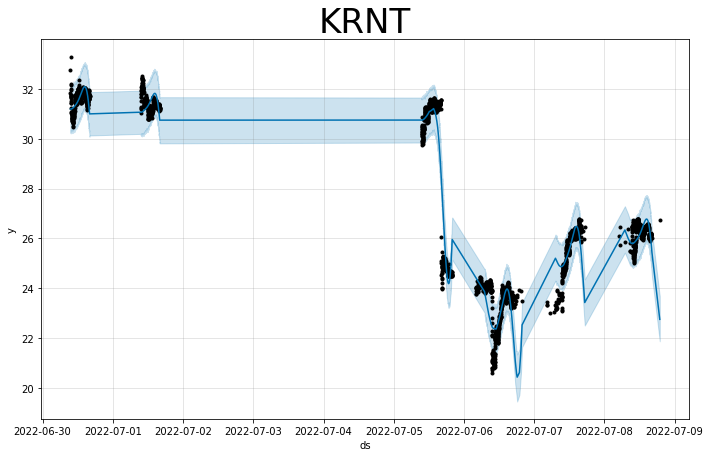

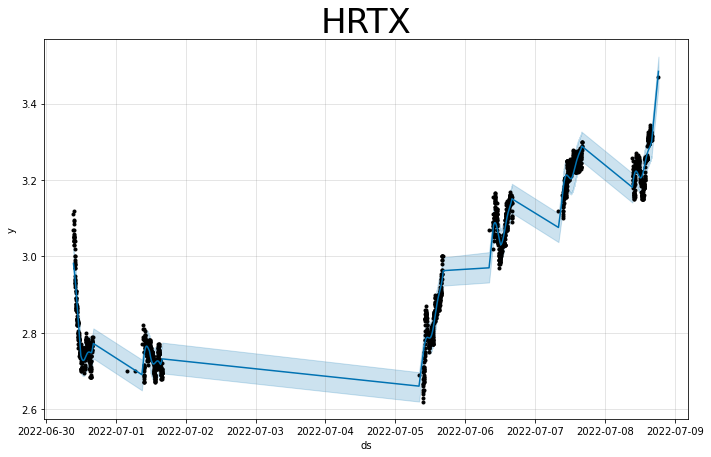

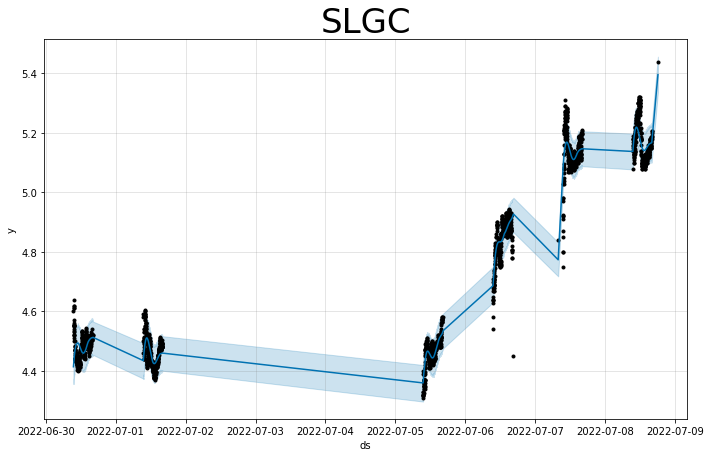

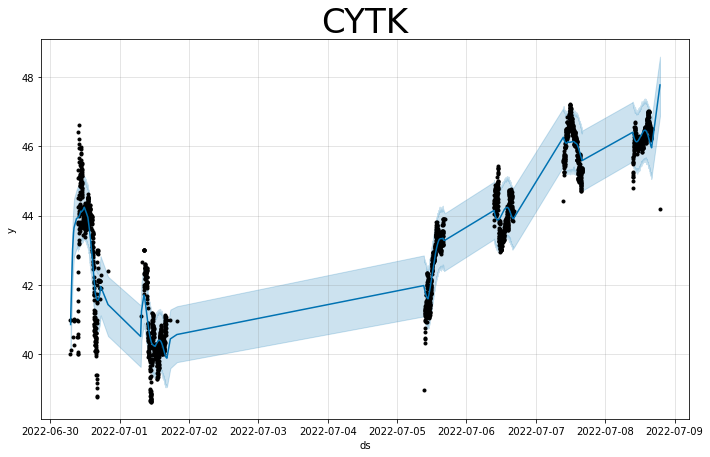

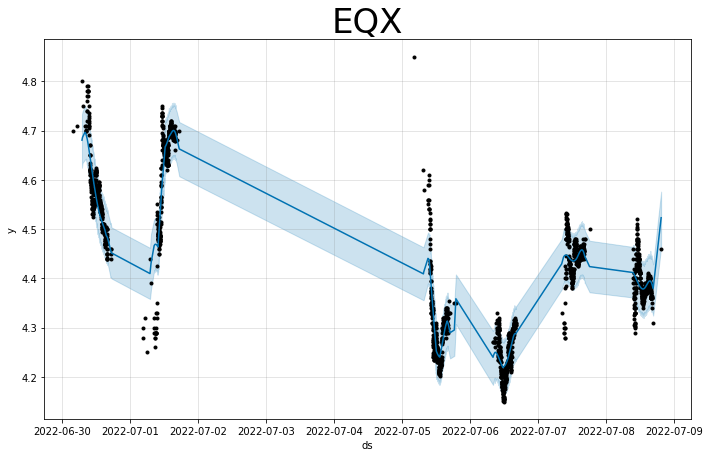

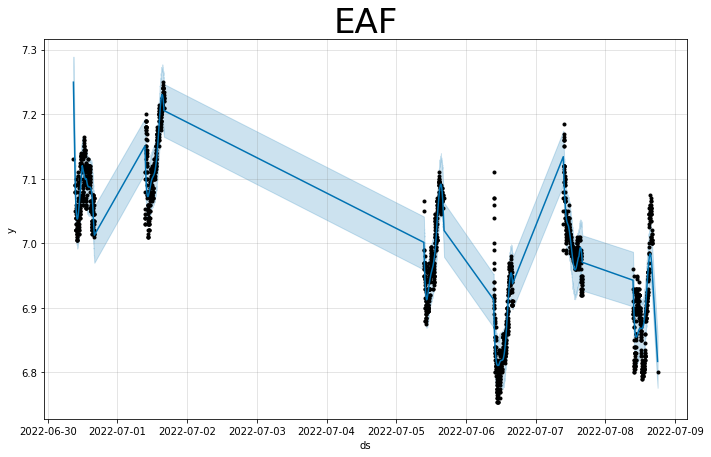

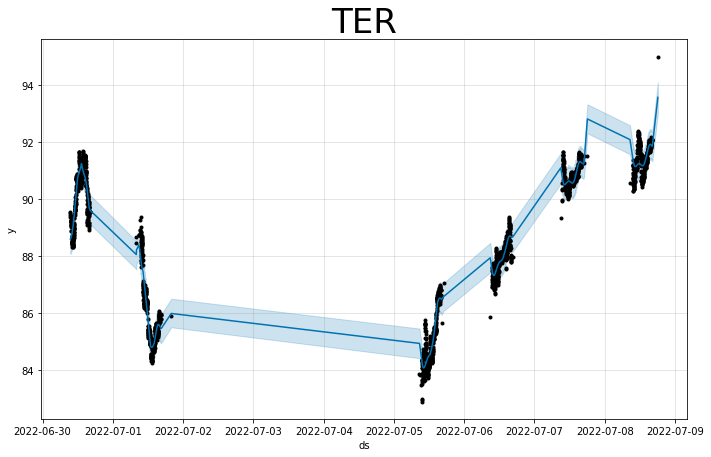

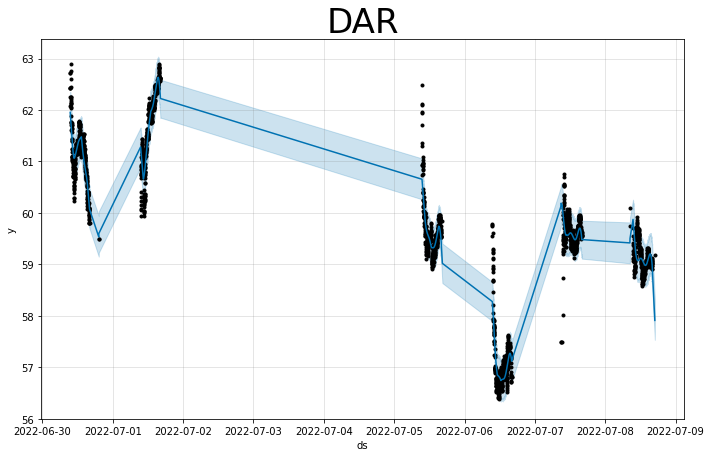

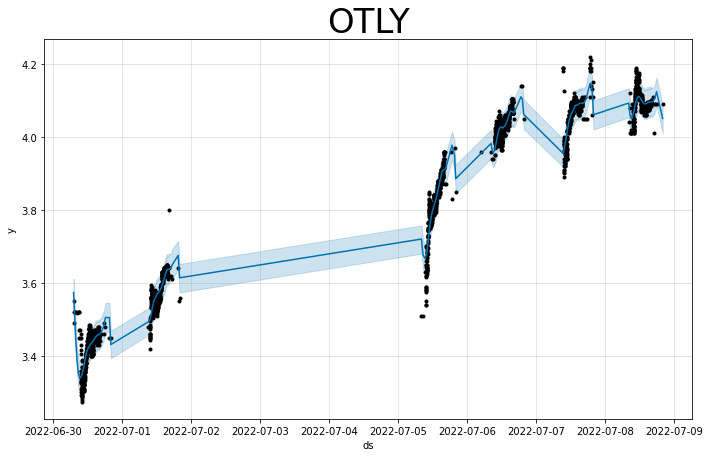

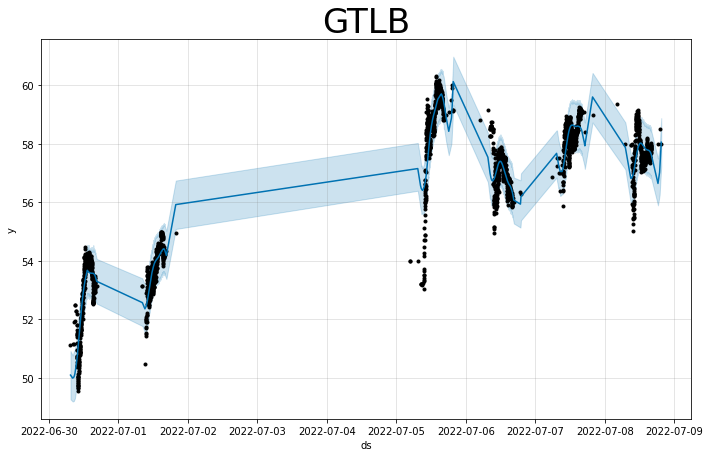

In [9]:
# Plot top ranks
itoprint = 10 # How many in ranking to print
i = 0
while(i < len(ranks) and i < itoprint):
    fig = ranks[i]['m'].plot(ranks[i]['forecast'])
    ax = fig.gca()
    ax.set_title(ranks[i]['symbol'], size=34)
    #ranks[i]['m'].plot_components(ranks[i]['forecast'])
    i = i + 1